## Part 0: Imports and Dataset

These two cell will import the credit card fraud dataset from kagglehub, as well as load in the dataset, alongside all necessary libraries used as part of this notebook.

In [2]:
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')

Data source import complete.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import (precision_score, recall_score, f1_score,
  roc_auc_score, accuracy_score, classification_report, confusion_matrix)
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## Part 1: Visualize Dataset Features

These cells will analyze the dataset and visualize a sample of the data, as well as describe it in terms of mean, median, quartiles...etc. and clean up the data to avoid null values and standardize it.

In [4]:
# read in data and see top 5 rows
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# visualize feature statistics (mean, median, quartiles...etc.) per feature
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# verify there are no null values
df.isnull().sum().max()

0

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


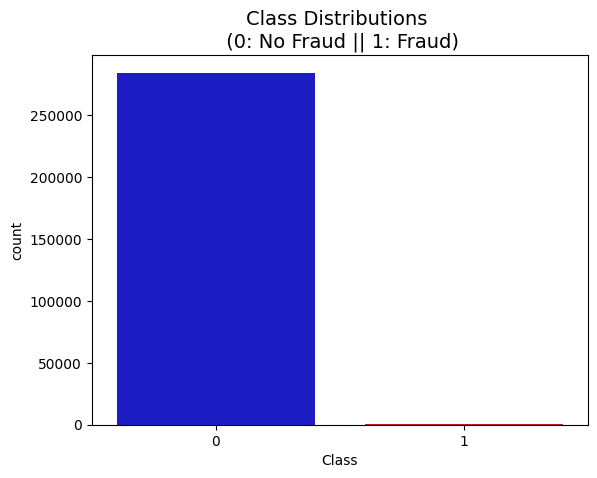

In [8]:
# validate that the dataset is highly imbalanced
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette = colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [9]:
# standardize the data using the sci-kit learn scalars
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Part 2: Model Extension by Fayez & Issa

This part of the code involves training the two new models that were not used in the initial paper, so we can compare against the models used by the original author. We propose training 3 new models:

1. Naive Bayes on Imbalanced Dataset
2. Naive Bayes on Balanced Dataset
3. MLP Classifier Neural Network on Imbalanced Dataset

In [10]:
# remove labels from data and split into training / testing datasets
X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1, Train Loss: 0.0053, Val Loss: 0.0016, LR: 0.001000
Epoch 2, Train Loss: 0.0011, Val Loss: 0.0015, LR: 0.001000
Epoch 3, Train Loss: 0.0009, Val Loss: 0.0015, LR: 0.001000
Epoch 4, Train Loss: 0.0009, Val Loss: 0.0014, LR: 0.001000
Epoch 5, Train Loss: 0.0008, Val Loss: 0.0014, LR: 0.001000
Epoch 6, Train Loss: 0.0008, Val Loss: 0.0015, LR: 0.001000
Epoch 7, Train Loss: 0.0007, Val Loss: 0.0015, LR: 0.001000
Epoch 8, Train Loss: 0.0007, Val Loss: 0.0015, LR: 0.001000
Epoch 9, Train Loss: 0.0007, Val Loss: 0.0014, LR: 0.001000
Epoch 10, Train Loss: 0.0006, Val Loss: 0.0015, LR: 0.000500
Epoch 11, Train Loss: 0.0006, Val Loss: 0.0015, LR: 0.000500
Epoch 12, Train Loss: 0.0007, Val Loss: 0.0015, LR: 0.000500
Epoch 13, Train Loss: 0.0006, Val Loss: 0.0015, LR: 0.000500
Epoch 14, Train Loss: 0.0006, Val Loss: 0.0016, LR: 0.000500
Epoch 15, Train Loss: 0.0005, Val Loss: 0.0016, LR: 0.000500
Epoch 16, Train Loss: 0.0005, Val Loss: 0.0017, LR: 0.000250
Epoch 17, Train Loss: 0.0005, Val

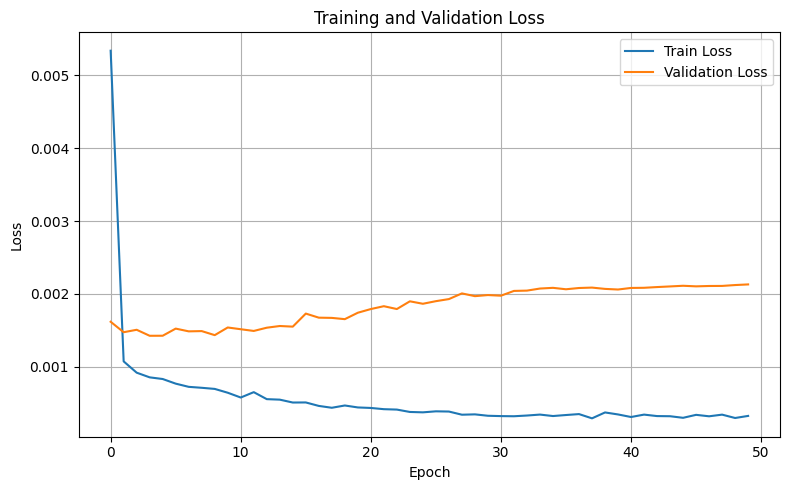

MLP Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56861     3]
 [   22    76]]


In [11]:
# Prepare data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(original_Xtrain.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(original_ytrain.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(original_Xtest.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(original_ytest.values, dtype=torch.float32).unsqueeze(1).to(device)

# Split training data into train and validation sets
val_ratio = 0.2
val_size = int(len(X_train_tensor) * val_ratio)
train_size = len(X_train_tensor) - val_size
train_data, val_data = random_split(TensorDataset(X_train_tensor, y_train_tensor), [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)

# Define MLP model
class FraudMLP(nn.Module):
    def __init__(self, input_dim):
        super(FraudMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

model = FraudMLP(original_Xtrain.shape[1]).to(device)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss) if self.reduce else F_loss

# Loss and optimizer
criterion = FocalLoss(alpha=1, gamma=2, logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)

# Training loop with early stopping
num_epochs = 50
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            val_loss = criterion(outputs, y_val)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    y_pred_probs = torch.sigmoid(logits)
    y_pred_labels = (y_pred_probs > 0.5).int().cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

# Results
print("MLP Classification Report:")
print(classification_report(y_true, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))

In [12]:
# NAIVE BAYES ON UNBALANCED DATA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier (assumes X_train, X_test, y_train, y_test already defined)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
labels = ['No Fraud', 'Fraud']
y_pred_nb = nb_model.predict(original_Xtest)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(original_ytest, y_pred_nb, target_names=labels))
print("Confusion Matrix:")
print(confusion_matrix(original_ytest, y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56864
       Fraud       0.06      0.82      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.90      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix:
[[55619  1245]
 [   18    80]]


In [13]:
# NAIVE BAYES ON BALANCED DATA
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

# random undersampling
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

X_balanced, y_balanced = new_df.drop('Class', axis=1), new_df['Class']

# NAIVE BAYES ON Balanced DATA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Train a Naive Bayes classifier (assumes X_train, X_test, y_train, y_test already defined)
nb_model = GaussianNB()
nb_model.fit(X_balanced, y_balanced)
labels = ['No Fraud', 'Fraud']
y_pred_nb = nb_model.predict(original_Xtest)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(original_ytest, y_pred_nb, target_names=labels))
print("Confusion Matrix:")
print(confusion_matrix(original_ytest, y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    No Fraud       1.00      0.96      0.98     56863
       Fraud       0.04      0.83      0.07        98

    accuracy                           0.96     56961
   macro avg       0.52      0.90      0.53     56961
weighted avg       1.00      0.96      0.98     56961

Confusion Matrix:
[[54868  1995]
 [   17    81]]


## Part 3: Original Code by Janio Martinez Bachmann

The rest of the code is the original code as part of the original project we are extending, this code continues to train the rest of the models that we will compare our models against.

In [14]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [15]:
# random undersampling
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
132818,-0.171592,-0.053654,-1.321463,1.667360,0.411521,-0.313764,-0.233672,-0.208786,-0.090005,0.958964,...,0.081184,-0.170599,-0.628851,-0.033601,-0.502780,0.005001,0.112358,0.129049,0.027746,0
63634,1.089779,-0.398078,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,...,0.816652,0.926157,-0.817706,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,1
82497,0.180954,-0.296831,1.351039,-0.560986,0.055673,-0.419855,-0.975166,-1.065274,-0.219358,-0.275327,...,-0.474513,-0.437910,-0.741456,-0.023487,0.433195,0.406799,1.090139,-0.077317,0.001907,0
154684,-0.307273,0.210059,-28.709229,22.057729,-27.855811,11.845013,-18.983813,6.474115,-43.557242,-41.044261,...,11.059004,-22.797604,8.316275,5.466230,0.023854,-1.527145,-0.145225,-5.682338,-0.439134,1
102444,-0.293440,-0.193670,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,...,-3.493050,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


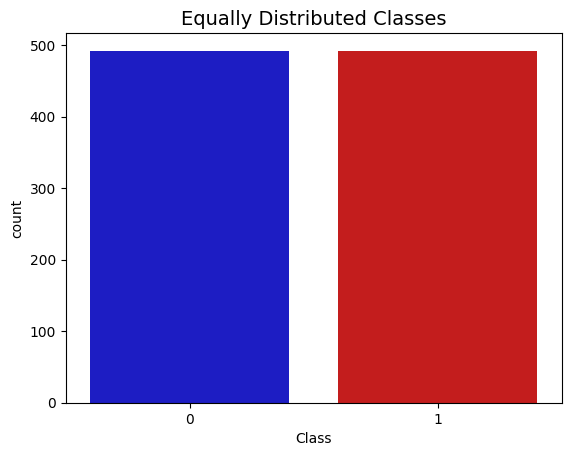

In [16]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

# Explicitly pass 'Class' to the 'x' argument and the dataframe to the 'data' argument
sns.countplot(x='Class', data=new_df, palette = colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

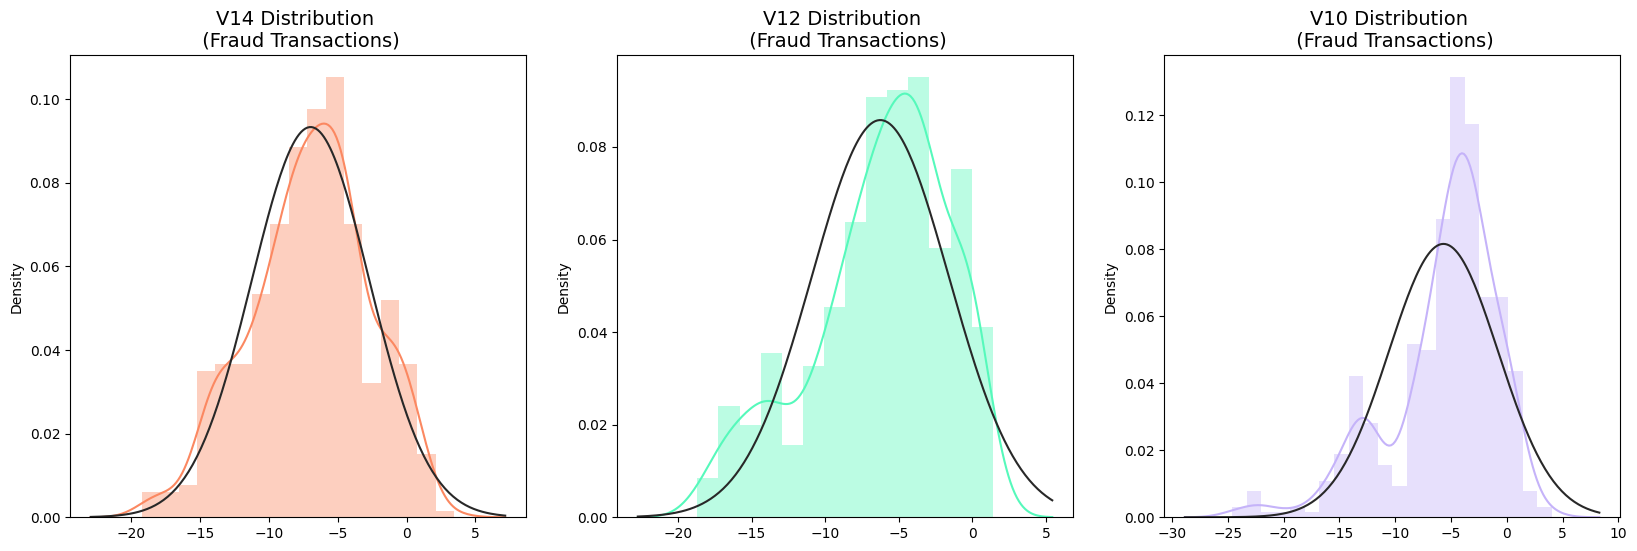

In [17]:
# removing outliers from the dataset
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [18]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[np.float64(-18.4937733551053), np.float64(-19.2143254902614), np.float64(-18.8220867423816), np.float64(-18.0499976898594)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [np.float64(-18.6837146333443), np.float64(-18.0475965708216), np.float64(-18.4311310279993), np.float64(-18.5536970096458)]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lo

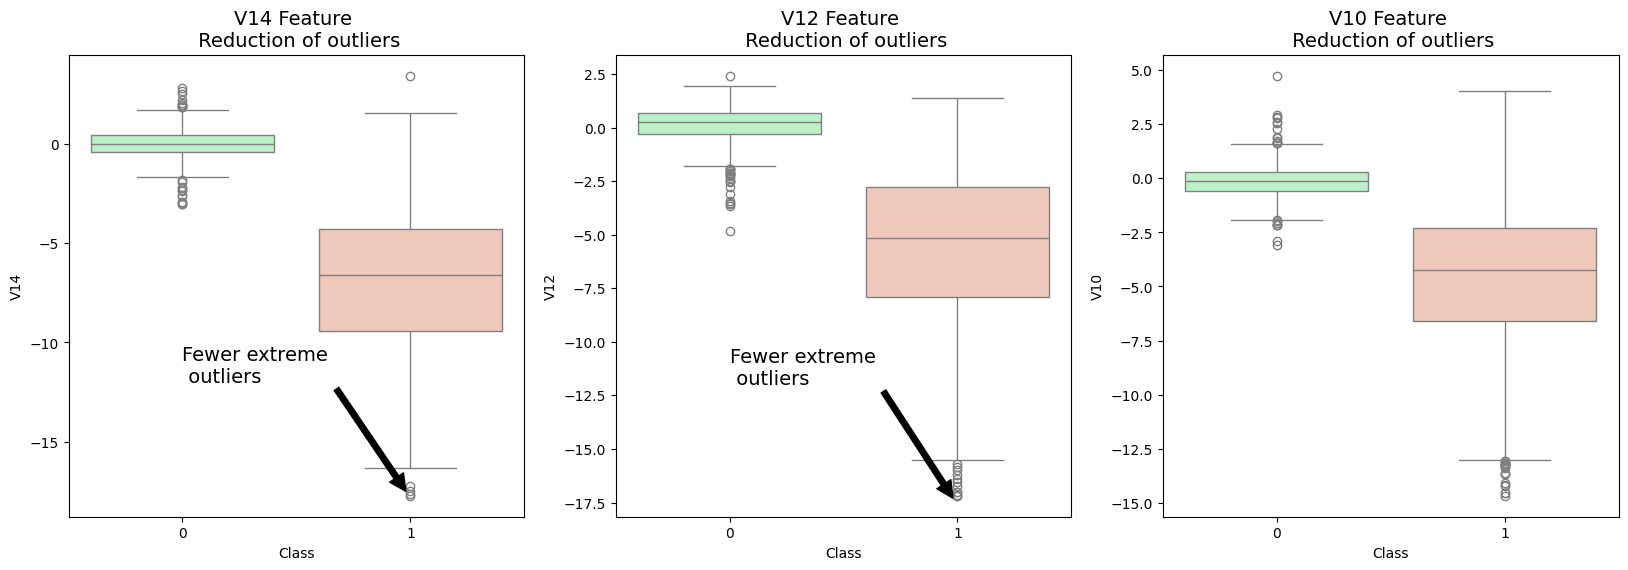

In [19]:
# removing outliers from dataset
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

In [20]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [21]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [24]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 92.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


In [25]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [26]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.1%
Knears Neighbors Cross Validation Score 92.83%
Support Vector Classifier Cross Validation Score 93.23%
DecisionTree Classifier Cross Validation Score 92.16%


In [27]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# Changed fit_sample to fit_resample
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56954  56955  56956 ... 284804 284805 284806] Test: [    0     1     2 ... 58943 59002 59092]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56954  56955  56956 ... 113923 113924 113925]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113016 113897 113926 ... 170882 171171 171191]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170883 170884 170885 ... 227843 227844 227845]
Train: [     0      1      2 ... 227843 227844 227845] Test: [227846 227847 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({np.int64(0): 492, np.int64(1): 492})


In [28]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# Changed fit_sample to fit_resample
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    # Use numpy indexing to select rows by integer index from original_Xtrain and original_ytrain
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56954  56955  56956 ... 284804 284805 284806] Test: [    0     1     2 ... 58943 59002 59092]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56954  56955  56956 ... 113923 113924 113925]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113016 113897 113926 ... 170882 171171 171191]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170883 170884 170885 ... 227843 227844 227845]
Train: [     0      1      2 ... 227843 227844 227845] Test: [227846 227847 227848 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({np.int64(0): 492, np.int64(1): 492})


In [29]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [30]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9740870032223415
KNears Neighbors:  0.9270697891344903
Support Vector Classifier:  0.9817895302165187
Decision Tree Classifier:  0.9204731754197524


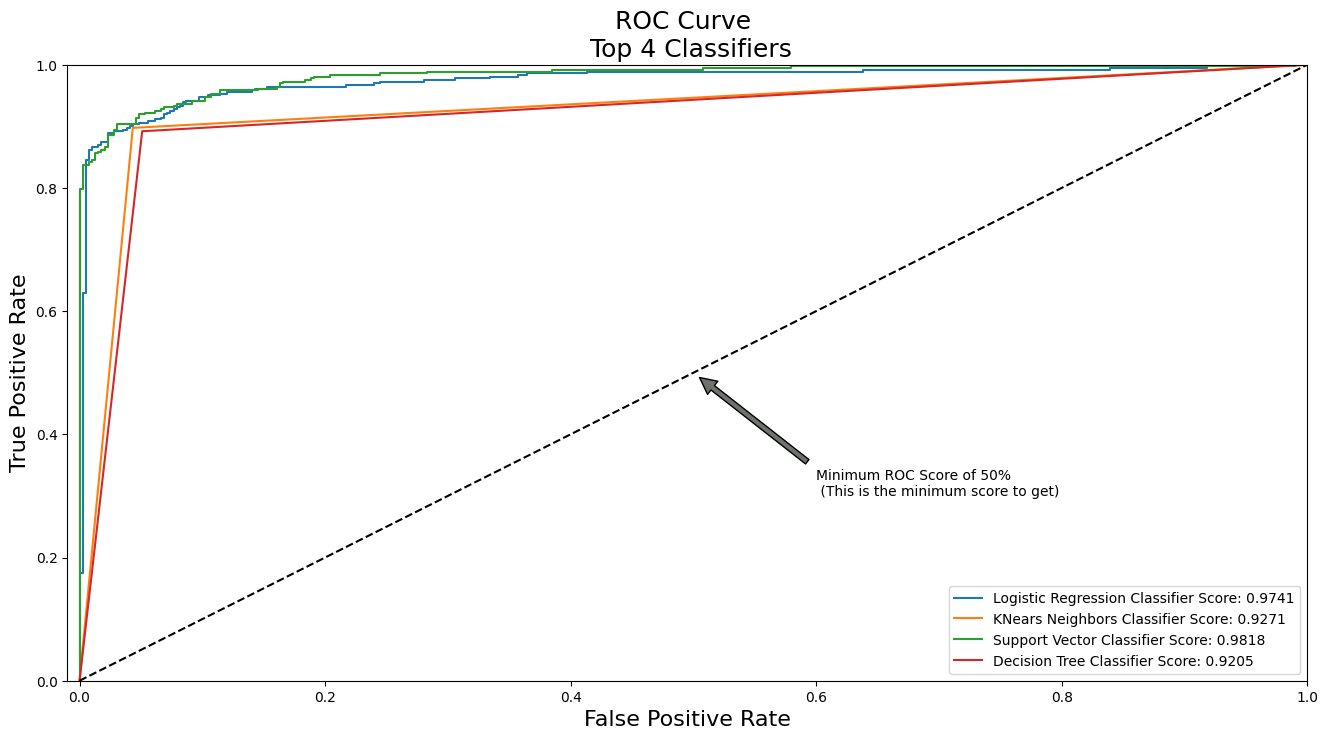

In [31]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

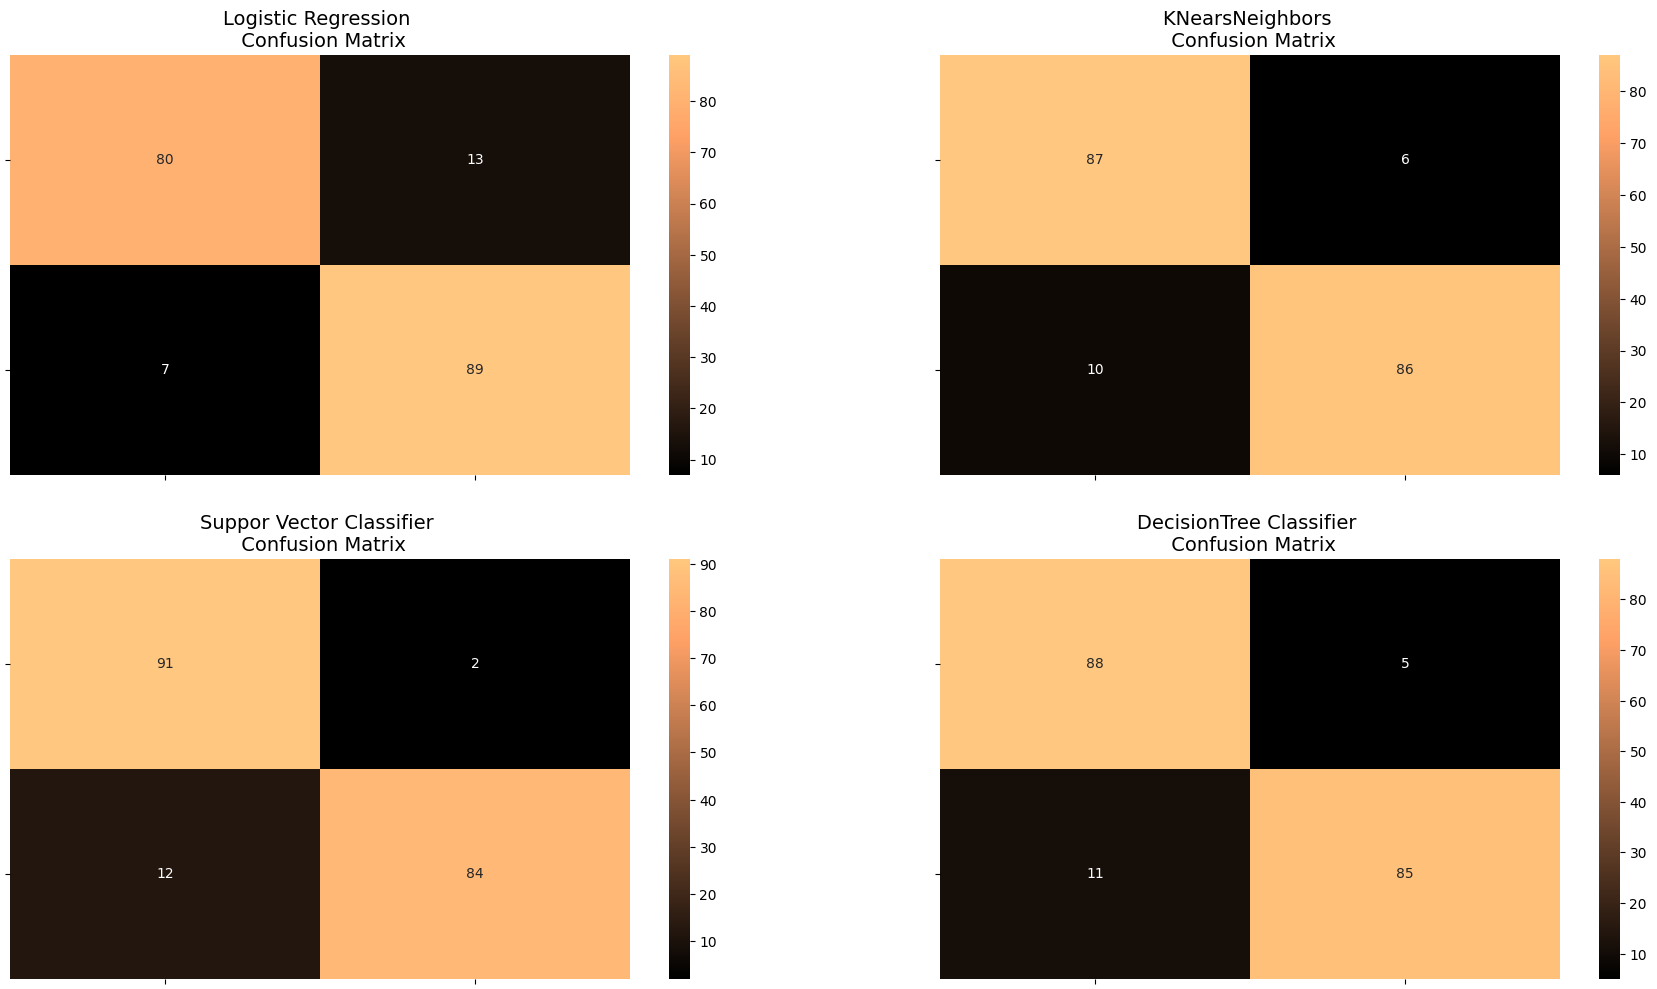

In [32]:
from sklearn.metrics import confusion_matrix

# Other models fitted with UnderSampling
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [33]:
log_reg_cf = classification_report(y_test, y_pred_log_reg, target_names=labels)
kneighbors_cf = classification_report(y_test, y_pred_knear, target_names=labels)
svc_cf = classification_report(y_test, y_pred_svc, target_names=labels)
tree_cf = classification_report(y_test, y_pred_tree, target_names=labels)

print("Logisitc Regression Report:")
print(log_reg_cf)

print("K Neighbors Report:")
print(kneighbors_cf)

print("SVC Report:")
print(svc_cf)

print("Tree Report:")
print(tree_cf)

Logisitc Regression Report:
              precision    recall  f1-score   support

    No Fraud       0.92      0.86      0.89        93
       Fraud       0.87      0.93      0.90        96

    accuracy                           0.89       189
   macro avg       0.90      0.89      0.89       189
weighted avg       0.90      0.89      0.89       189

K Neighbors Report:
              precision    recall  f1-score   support

    No Fraud       0.90      0.94      0.92        93
       Fraud       0.93      0.90      0.91        96

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted avg       0.92      0.92      0.92       189

SVC Report:
              precision    recall  f1-score   support

    No Fraud       0.88      0.98      0.93        93
       Fraud       0.98      0.88      0.92        96

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg  

In [34]:
# testing on original data

y_pred_log_reg = log_reg.predict(original_Xtest)
y_pred_knear = knears_neighbors.predict(original_Xtest)
y_pred_svc = svc.predict(original_Xtest)
y_pred_tree = tree_clf.predict(original_Xtest)

log_reg_cf = classification_report(original_ytest, y_pred_log_reg, target_names=labels)
kneighbors_cf = classification_report(original_ytest, y_pred_knear, target_names=labels)
svc_cf = classification_report(original_ytest, y_pred_svc, target_names=labels)
tree_cf = classification_report(original_ytest, y_pred_tree, target_names=labels)

print("Logisitc Regression Report:")
print(log_reg_cf)

print("K Neighbors Report:")
print(kneighbors_cf)

print("SVC Report:")
print(svc_cf)

print("Tree Report:")
print(tree_cf)

Logisitc Regression Report:
              precision    recall  f1-score   support

    No Fraud       1.00      0.80      0.89     56863
       Fraud       0.01      0.89      0.02        98

    accuracy                           0.80     56961
   macro avg       0.50      0.85      0.45     56961
weighted avg       1.00      0.80      0.89     56961

K Neighbors Report:
              precision    recall  f1-score   support

    No Fraud       1.00      0.95      0.98     56863
       Fraud       0.03      0.93      0.07        98

    accuracy                           0.95     56961
   macro avg       0.52      0.94      0.52     56961
weighted avg       1.00      0.95      0.98     56961

SVC Report:
              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.09      0.88      0.17        98

    accuracy                           0.99     56961
   macro avg       0.55      0.93      0.58     56961
weighted avg  

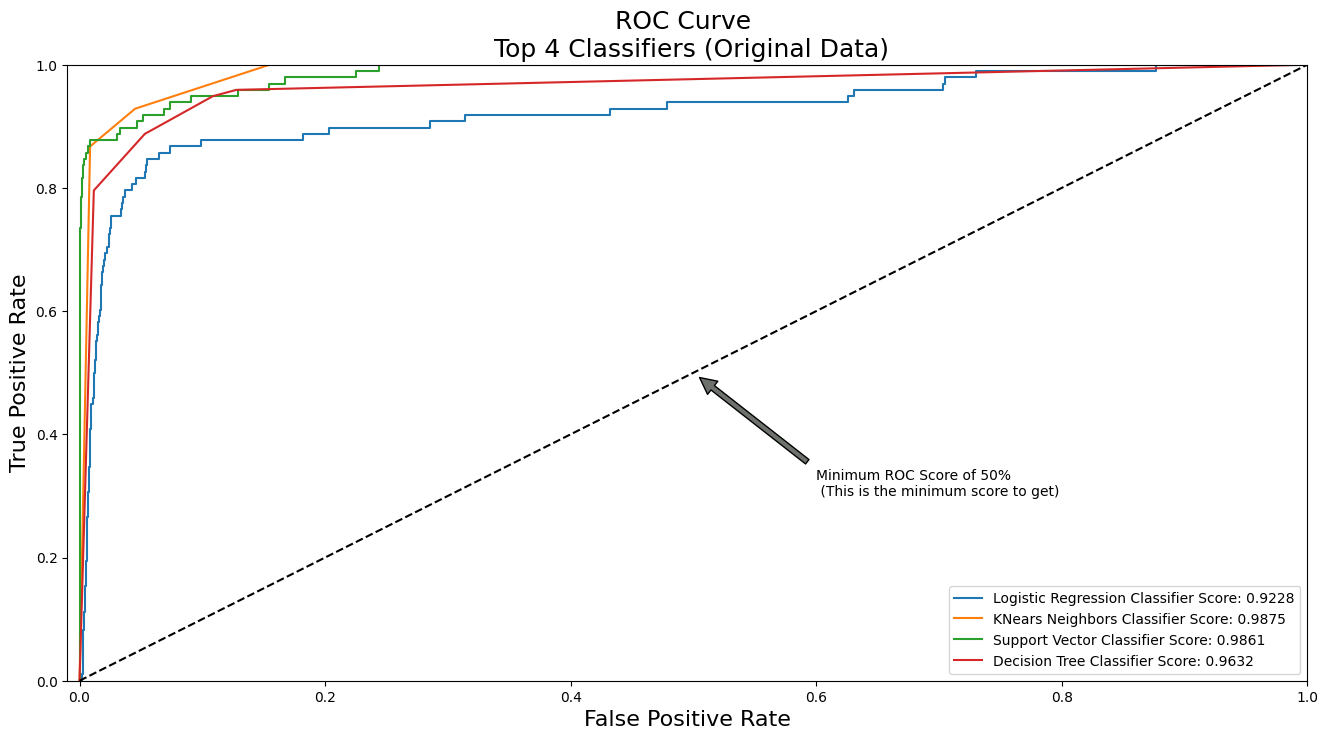

In [35]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Make predictions using the already trained models on the original imbalanced test set
# Ensure you have original_Xtest and original_ytest available from previous steps

# Get probabilities for the positive class for applicable models
log_reg_pred_original = log_reg.predict_proba(original_Xtest)[:, 1]
knears_pred_original = knears_neighbors.predict_proba(original_Xtest)[:, 1]
tree_pred_original = tree_clf.predict_proba(original_Xtest)[:, 1]
# Get decision function scores for SVC
svc_pred_original = svc.decision_function(original_Xtest)


# Calculate ROC curve values for the original imbalanced data
log_fpr_orig, log_tpr_orig, log_thresold_orig = roc_curve(original_ytest, log_reg_pred_original)
knear_fpr_orig, knear_tpr_orig, knear_threshold_orig = roc_curve(original_ytest, knears_pred_original)
svc_fpr_orig, svc_tpr_orig, svc_threshold_orig = roc_curve(original_ytest, svc_pred_original)
tree_fpr_orig, tree_tpr_orig, tree_threshold_orig = roc_curve(original_ytest, tree_pred_original)

# Define the plotting function for the original data
def graph_roc_curve_multiple_original(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, y_true, log_pred, knear_pred, svc_pred, tree_pred):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers (Original Data)', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_true, log_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_true, knear_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_true, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_true, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

# Call the plotting function with the data from the original test set
graph_roc_curve_multiple_original(log_fpr_orig, log_tpr_orig, knear_fpr_orig, knear_tpr_orig, svc_fpr_orig, svc_tpr_orig, tree_fpr_orig, tree_tpr_orig, original_ytest, log_reg_pred_original, knears_pred_original, svc_pred_original, tree_pred_original)
plt.show()